# BRAZIL CHAMPIONSHIP SERIE A

In [111]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
from selenium import webdriver
import time
import matplotlib.pyplot as plt

# DATA

## Teams

In [3]:
brazil_serieA = {'atletico_mg':'atletico-mg/317','atletico_pr':'atletico-pr/315','avai':'avai/330','bahia':'bahia/341',
                 'botafogo':'botafogo/323','ceara':'ceara/333','chapecoense':'chapecoense/6223','corinthians':
                 'corinthians/320','cruzeiro':'cruzeiro/304','csa':'csa/6294','flamengo':'flamengo/318','fluminense':
                 'fluminense/312','fortaleza':'fortaleza/327','goias':'goias/307','gremio':'gremio/313','internacional':
                 'internacional/308','palmeiras':'palmeiras/310','santos':'santos/319','sao_paulo':'sao-paulo/302',
                 'vasco':'vasco/321'}

## Webdriver

In [13]:
def prepare_website(team):
    
    #chose the tem you wanto to know the results
    website = 'https://www.academiadasapostasbrasil.com/stats/team/brasil/'+brazil_serieA[team]
    
    #driver Google Chrome
    chrome = webdriver.Chrome()
    chrome.get(website)
    time.sleep(10)

    #select the statistics
    button = chrome.find_elements_by_class_name('marketselector')
    button[2].click()
    time.sleep(10)
    
    return chrome

## Team Calendar

In [119]:
def calendar(team):
    #chose the tem you wanto to know the results
    website = 'https://www.academiadasapostasbrasil.com/stats/team/brasil/'+brazil_serieA[team]
    #get the html from the website
    source = requests.get(website).text
    soup_calendar = BeautifulSoup(source,'lxml')

    #get the content from the table
    table_next_games = soup_calendar.find('table',{'class':'next-games'})
    content_next_games = table_next_games.get_text().split('\n')

    #cleaning data
    content_next_games = list(filter(None,content_next_games)) 
    content_next_games = np.asarray(content_next_games[6:])

    #creating a data frame and dropping unnecessary columns
    df_next_games = pd.DataFrame(np.hsplit(content_next_games,30)).drop(columns = [3,5,6,8], axis = 1)
    df_next_games = df_next_games.rename(columns ={0:'date',1:'time',2:'championship',4:'home',7:'score',9:'away'})
    
    return df_next_games

## Team Statistics

### Season

In [80]:
def season(webdriver):

    #get the content from the table
    tab_stats = webdriver.find_elements_by_class_name('next-games.team_stats') 
    soup_season = BeautifulSoup(tab_stats[0].get_attribute("innerHTML"), "html.parser")

    #cleaning data
    content_season = soup_season.get_text().split('\n')
    content_season = list(filter(None,content_season))
    content_season = np.asarray(content_season[13:])

    #creating a data frame and rename columns
    df_season = pd.DataFrame(np.hsplit(content_season,7))
    df_season = df_season.rename(columns = {0:'feature',1:'total_serieA_2019',2:'home_serieA_2019',3:'away_serieA_2019',
                                   4:'total_6_matches',5:'home_6_matches',6:'away_6_matches',7:'total_21_matches',
                                   8:'home_21_matches',9:'away_21_matches'}).set_index('feature')
    df_season = df_season.apply(pd.to_numeric)
    
    
    return df_season
    

### Performance

In [83]:
def performance(webdriver):
    
    #get the content from the table
    tab_stats = webdriver.find_elements_by_class_name('next-games.team_stats') 
    soup_performance = BeautifulSoup(tab_stats[1].get_attribute("innerHTML"), "html.parser")

    #cleaning data
    content_performance = soup_performance.get_text().split('\n')
    content_performance = list(filter(None,content_performance))
    content_performance = np.asarray(content_performance[2:])

    #creating a data frame and rename columns
    df_performance = pd.DataFrame(np.hsplit(content_performance,19))
    df_performance = df_performance.rename(columns = {0:'feature',1:'total',2:'game'}).set_index('feature')
    df_performance = df_performance.apply(pd.to_numeric)
    
    return df_performance

### Goal Times

In [102]:
def goals_times(webdriver):
        
    #get the content from the table
    tab_goals = webdriver.find_elements_by_class_name('competition-class.goals_moments')
    soup_goals = BeautifulSoup(tab_goals[1].get_attribute("innerHTML"), "html.parser")

    #cleaning data
    content_goals = soup_goals.get_text().split('\n')
    content_goals = list(filter(None,content_goals))
    content_goals = np.asarray(content_goals[2:])
    
    #creating a data frame and rename columns
    df = pd.DataFrame(np.hsplit(content_goals,18))
    df_aux = pd.merge(df[6:12],df[12:], on = 0)
    df_goals = pd.merge(df_aux,df[0:6], on = 0)
    df_goals = df_goals[[0,'1_x','1_y',1]].rename(columns = {0:'time','1_x':'home_goals','1_y':'away_goals',
                                                           1:'total_goals'}).set_index('time')
    df_goals = df_goals.apply(pd.to_numeric)
    
    return df_goals

In [403]:
def plot_goal_times(df_home,df_away):
    
    # Make figure and axes
    fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 15))
    colors = ['orangered','orange','gold','greenyellow', 'yellowgreen','lightcoral']
    r = 1.2
  
    
    # Home team pie plot
    axs[0, 0].pie(df_home['home_goals'], autopct='%1.1f%%', radius = r, colors = colors)
    axs[0, 1].pie(df_home['away_goals'], autopct='%1.1f%%', radius = r, colors = colors)
    axs[0, 2].pie(df_home['total_goals'], autopct='%1.1f%%', radius = r, colors = colors)
    
    
    # Away team pie plot
    axs[1, 0].pie(df_away['home_goals'], autopct='%1.1f%%', radius = r, colors = colors)
    axs[1, 1].pie(df_away['away_goals'], autopct='%1.1f%%', radius = r, colors = colors)
    axs[1, 2].pie(df_away['total_goals'], autopct='%1.1f%%', radius = r, colors = colors)
    
    plt.legend(df_home.index,
               title="Goal Times",
               loc="best",
               fontsize = 15,
               title_fontsize = 20,
               bbox_to_anchor=(1,-0.2))
    
    plt.text(x = -7,y = 5, s = home_team, fontsize = 25)
    plt.text(x = -7,y = 1.8, s = away_team, fontsize = 25)
    plt.text(x = -6.2,y = 1.32, s = 'Home', fontsize = 15)
    plt.text(x = -3.12,y = 1.32, s = 'Away', fontsize = 15)
    plt.text(x = -0.12,y = 1.32, s = 'Total', fontsize = 15)
    plt.text(x = -6.2,y = 4.7, s = 'Home', fontsize = 15)
    plt.text(x = -3.12,y = 4.7, s = 'Away', fontsize = 15)
    plt.text(x = -0.12,y = 4.7, s = 'Total', fontsize = 15)
    plt.show()

# VISUALIZATION

## Choose the teams

In [405]:
home_team = 'corinthians'
away_team = 'flamengo'
home = prepare_website(home_team)
away = prepare_website(away_team)

### Home Team Goal Times

In [406]:
df_home_team =  goals_times(home)
df_home_team 

,home_goals,away_goals,total_goals
time,,,
0-15,2,2,4
16-30,3,2,5
31-45,6,3,9
46-60,5,1,6
61-75,4,3,7
76-90,4,7,11


### Away Team Goal Times

In [407]:
df_away_team =  goals_times(away)
df_away_team 

,home_goals,away_goals,total_goals
time,,,
0-15,7,4,11
16-30,2,1,3
31-45,15,8,23
46-60,8,5,13
61-75,12,4,16
76-90,12,8,20


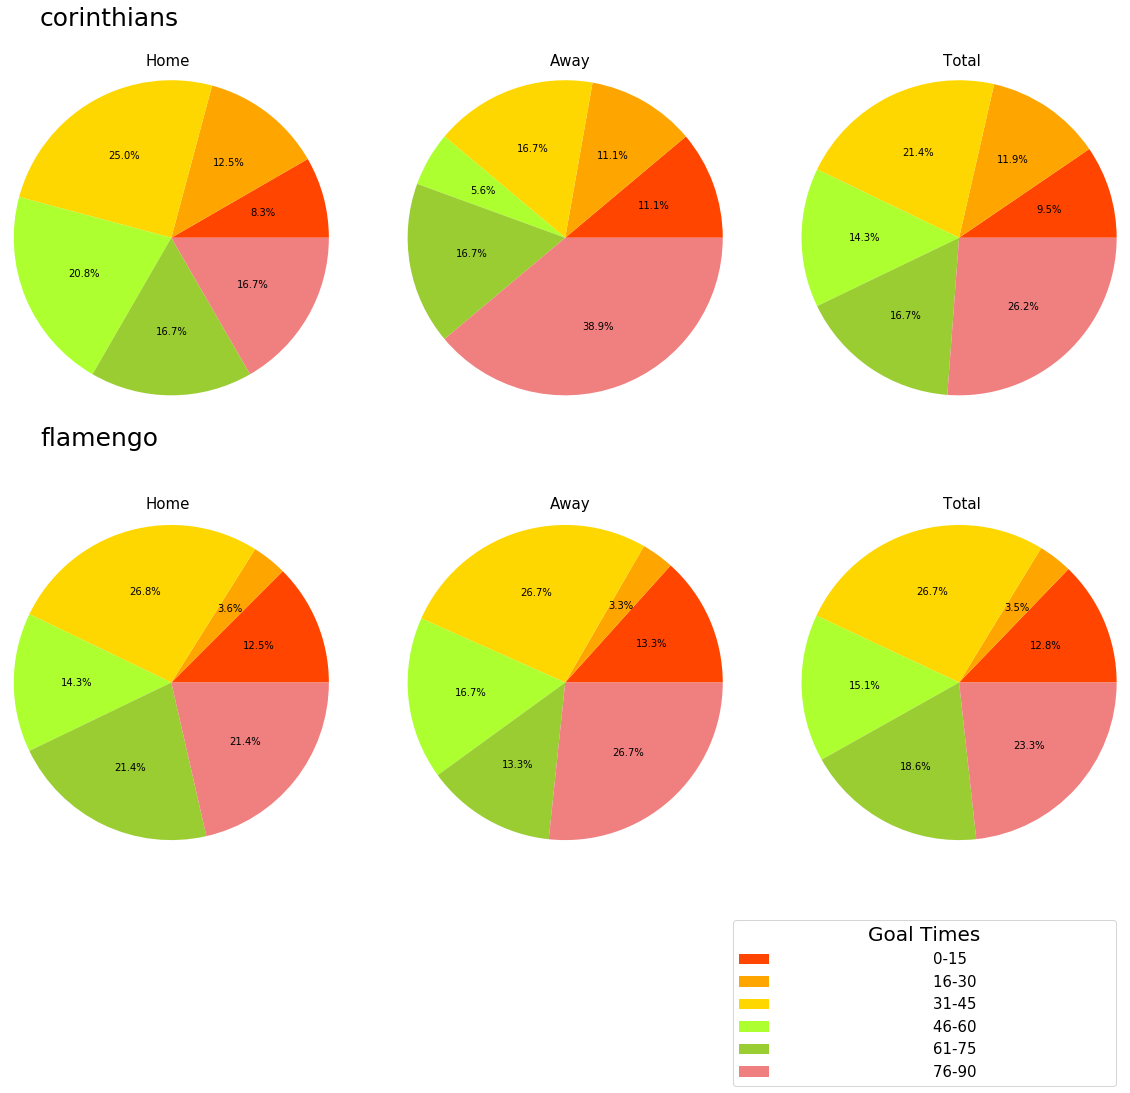

In [408]:
plot_goal_times(df_home_team,df_away_team)